# Washington State:Kings County:Houses:SGD Test
#### bdanalytics

In [1]:
print(format(Sys.time(), "(%a) %b %d, %Y"))

[1] "(Thu) Mar 03, 2016"


In [2]:
require(doMC)
glbCores <- 6 # of cores on machine - 2
registerDoMC(glbCores)

require(Cairo)
#require(dplyr)
#require(ggplot2)
#require(jpeg)
#require(reshape2)
source("~/Dropbox/datascience/R/mydsutils.R")
source("~/Dropbox/datascience/R/myplot.R")

Loading required package: doMC
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: Cairo
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


## Analytics Specs

In [3]:
glbObsTrnFile <- list(name = "kc_house_train_data.csv")
glbObsNewFile <- list(name = "kc_house_test_data.csv")
glb_rsp_var_raw <- "price"
glb_rsp_var <- glb_rsp_var_raw
glbObsTrnPartitionSeed <- 123

glbFeats <- c('sqft_living', 'sqft_living15')

## Import Data

In [4]:
glbObsTrn <- myimport_data(specs = glbObsTrnFile, comment = "glbObsTrn", 
                           force_header = TRUE)

[1] "Reading file ./data/kc_house_train_data.csv..."
[1] "dimensions of data in ./data/kc_house_train_data.csv: 17,384 rows x 21 cols"
          id            date   price bedrooms bathrooms sqft_living sqft_lot
1 7129300520 20141013T000000  221900        3      1.00        1180     5650
2 6414100192 20141209T000000  538000        3      2.25        2570     7242
3 5631500400 20150225T000000  180000        2      1.00         770    10000
4 2487200875 20141209T000000  604000        4      3.00        1960     5000
5 1954400510 20150218T000000  510000        3      2.00        1680     8080
6 7237550310 20140512T000000 1225000        4      4.50        5420   101930
  floors waterfront view condition grade sqft_above sqft_basement yr_built
1      1          0    0         3     7       1180             0     1955
2      2          0    0         3     7       2170           400     1951
3      1          0    0         3     6        770             0     1933
4      1          0    0  

Warning message:
In myprint_str_df(df): [list output truncated]

In [5]:
glbObsNew <- myimport_data(specs = glbObsNewFile, comment = "glbObsNew", 
                           force_header = TRUE)

[1] "Reading file ./data/kc_house_test_data.csv..."
[1] "dimensions of data in ./data/kc_house_test_data.csv: 4,229 rows x 21 cols"
          id            date  price bedrooms bathrooms sqft_living sqft_lot
1  114101516 20140528T000000 310000        3       1.0        1430    19901
2 9297300055 20150124T000000 650000        4       3.0        2950     5000
3 1202000200 20141103T000000 233000        3       2.0        1710     4697
4 8562750320 20141110T000000 580500        3       2.5        2320     3980
5 7589200193 20141110T000000 535000        3       1.0        1090     3000
6 2078500320 20140620T000000 605000        4       2.5        2620     7553
  floors waterfront view condition grade sqft_above sqft_basement yr_built
1    1.5          0    0         4     7       1430             0     1927
2    2.0          0    3         3     9       1980           970     1979
3    1.5          0    0         5     6       1710             0     1941
4    2.0          0    0         3  

Warning message:
In myprint_str_df(df): [list output truncated]

## Partition data

In [6]:
set.seed(glbObsTrnPartitionSeed)
OOB_size <- nrow(glbObsNew) * 1.1
print(sprintf("Fit vs. OOB split ratio:%0.4f", 
              1 - (OOB_size * 1.0 / nrow(glbObsTrn))))

require(caTools)
split <- sample.split(glbObsTrn[, glb_rsp_var_raw], SplitRatio = OOB_size)
print(sum(split))
glbObsOOB <- glbObsTrn[ split, ]            
glbObsFit <- glbObsTrn[!split, ]
print(sprintf("glbObsFit:")); print(dim(glbObsFit))
print(sprintf("glbObsOOB:")); print(dim(glbObsOOB))

[1] "Fit vs. OOB split ratio:0.7324"


Loading required package: caTools


[1] 4652
[1] "glbObsFit:"
[1] 12732    21
[1] "glbObsOOB:"
[1] 4652   21


In [7]:
print(OOB_size)
print(OOB_size * 1.0 / nrow(glbObsTrn))

[1] 4651.9
[1] 0.2675966


## Fit models

In [8]:
weightsZero <- rep(0, 1 + length(glbFeats))
print(sprintf("weightsZero:"))
print(weightsZero)

[1] "weightsZero:"
[1] 0 0 0


In [9]:
predictOutput <- function(obsDf, feats, weights) {
    featMtrx <- cbind(matrix(rep(1.0, nrow(obsDf)), nrow = nrow(obsDf)),
                      as.matrix(obsDf[, feats]))
    #print(class(featMtrx))
    return(featMtrx %*% weights)
}

print(predictOutput(glbObsTrn, 'sqft_living', c(1.0, 1.0))[1]) # should be 1181.0
print(predictOutput(glbObsTrn, 'sqft_living', c(1.0, 1.0))[2]) # should be 2571.0

print(predictOutput(glbObsTrn, 'sqft_living', c(10.0, 2.0))[1]) # should be 2370.0
print(predictOutput(glbObsTrn, 'sqft_living', c(10.0, 2.0))[2]) # should be 5150.0

[1] 1181
[1] 2571
[1] 2370
[1] 5150


In [10]:
ridgeRegressionLossFn <- function(obsDf, feats, weights, l2Penalty) {
    loss <- sum((predictOutput(obsDf, feats, weights) - obsDf[, glb_rsp_var])
                ^ 2) +
                l2Penalty * sum(weights ^ 2)
    if (is.infinite(loss)) {
        print(sprintf(
            "ridgeRegressionLossFn: loss == Inf; l2Penalty:%0.4e; weights:", 
            l2Penalty))
        print(weights)
    }
    return(loss)    
}

In [11]:
ridgeRegressionLossGradientFn <- function(obsDf, feats, weights, l2Penalty, 
                                          featIx, isIntercept) {
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: nrow(obsDf):%d; l2Penalty:%0.4f; featIx:%d; isIntercept:%s",
#                       nrow(obsDf), l2Penalty, featIx, isIntercept))
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: weights:"))
#     print(weights)

    if (!isIntercept) {
        featX <- as.matrix(obsDf[, feats[featIx-1]])
    } else featX <- matrix(rep(1, nrow(obsDf)), nrow = nrow(obsDf))
    
    gradient <- 2 * 
                sum((predictOutput(obsDf, feats, weights) - 
                     obsDf[, glb_rsp_var]) *
                    featX)
    if (!isIntercept)
        gradient <- gradient + 2 * l2Penalty * weights[featIx]
        
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: featIx:%d; gradient:%0.4e",
#                   featIx, gradient))
    return(gradient)
}

In [35]:
autoLossGradientFn <- function(obsDf, feats, weights, l2Penalty, 
                                    featIx, isIntercept, verbose = FALSE) {
    gradientActual <- ridgeRegressionLossGradientFn(obsDf, feats, weights, 
                                    l2Penalty, featIx, isIntercept)
    
    if (verbose) {
        print(sprintf('autoLossGradientFn: weights[%d]: %.4e; isIntercept: %s;',
                     featIx, weights[featIx], isIntercept))
    }          
              
    return(gradientActual)
}

In [36]:
example_weights = c(1.0, 10.0)
example_predictions = predictOutput(glbObsTrn, 'sqft_living', example_weights)                
example_errors = example_predictions - glbObsTrn[, glb_rsp_var]        

# next three lines should print the same values
print(sum(example_errors * glbObsTrn[, 'sqft_living'])*2+20)
# print(example_errors[1:5])
# print(glbObsTrn[1:5, 'sqft_living'])
# print((example_errors * glbObsTrn[, 'sqft_living'])[1:5])
print(ridgeRegressionLossGradientFn(glbObsTrn, 'sqft_living', 
                                    example_weights, 
                                    l2Penalty = 1, featIx = 2, FALSE))        
print(autoLossGradientFn(glbObsTrn, 'sqft_living', 
                                    example_weights, 
                            l2Penalty = 1, featIx = 2, isIntercept = FALSE,
                        verbose = TRUE))        
        
# next two lines should print the same values
print('')
print(sum(example_errors)*2)
#print(example_errors[1:5])
print(ridgeRegressionLossGradientFn(glbObsTrn, 'sqft_living', 
                                    example_weights, 
                                    l2Penalty = 1, featIx = 1, TRUE))                

[1] -4.553289e+13
[1] -4.553289e+13
[1] "autoLossGradientFn: weights[2]: 1.0000e+01; isIntercept: FALSE;"
[1] -4.553289e+13
[1] ""
[1] -18029479492
[1] -18029479492


In [13]:
optimizeGradientDescent <- function(obsDf, feats, weightsInitial, 
                                    stepSize, l2Penalty, 
                                    lossFn, lossGradientFn, 
                                    maxIterations = 100, verbose = FALSE,
                                    maxLoss = 1e155) {
    
    if (verbose) {
        print(" ")
        print(sprintf("optimzeGradientDescent:")) 
    }    
    weights <- weightsInitial
    loss <- lossFn(obsDf, feats, weights, l2Penalty)    
    
    #while not reached maximum number of iterations:
    iterResults = data.frame(iterNum = 1:maxIterations)
    for (iterNum in 1:maxIterations) {
        if (verbose && 
            ((iterNum %% (maxIterations / 10) == 1) ||
             (iterNum <=10)))
            print(sprintf("  iteration: %d; loss:%0.4e", iterNum, loss))
            
        # loop over each weight            
        for (i in 1:length(weights)) {
            # compute the derivative for weight[i].
            #  when i=1, you are computing the derivative of the constant!
            gradient <- 
                lossGradientFn(obsDf, feats, weights, l2Penalty, 
                               i, (i == 1))
            
            # subtract the stepSize times the gradient from the 
            #   current weight
            weights[i] = weights[i] - stepSize * gradient
        }    
    
        loss <- lossFn(obsDf, feats, weights, l2Penalty)
        iterResults[iterNum, "loss"] <- loss
        for (featIx in 1:(length(feats) + 1)) {
            if (featIx == 1) 
                iterResults[iterNum, '.intercept'] <- weights[featIx] else
                iterResults[iterNum, feats[featIx - 1]] <- weights[featIx]                
        }    
        
        if (is.infinite(loss)) {
            warning("optimizeGradientDescent: loss is Inf")
            break
        }                
    }    

    if ((sum(      is.na(iterResults$loss)) > 0) ||
        (sum(is.infinite(iterResults$loss)) > 0))
        converged <- FALSE else converged <- TRUE

    # Display results at end of iterations
    if (verbose || !converged) {   
        myprint_df(iterResults)
        
        iterResultsIx <- ifelse(converged, nrow(iterResults),
                                            which(      is.na(iterResults$loss) |
                                                  is.infinite(iterResults$loss))[1] - 1)
        if (max(iterResults[1:iterResultsIx, 'loss']) > maxLoss) # geom_contour does not work
            iterResultsIx <- which(iterResults[1:iterResultsIx, 'loss'] > maxLoss)[1] - 1

        print(sprintf('iterResultsIx:%d', iterResultsIx))
        wgt1 <- iterResults[1:iterResultsIx, '.intercept']
        wgt2 <- iterResults[1:iterResultsIx, feats[1]]
        contourDf <- expand.grid(
                wgt1 = union(rnorm(10, 
                                mean(wgt1, na.rm = TRUE),
                                  sd(wgt1, na.rm = TRUE)),
                        union(+1 * range(wgt1, na.rm = TRUE),
                              +2 * range(wgt1, na.rm = TRUE))),
                wgt2 = union(rnorm(10, 
                                mean(wgt2, na.rm = TRUE),
                                  sd(wgt2, na.rm = TRUE)),
                        union(+1 * range(wgt2, na.rm = TRUE),
                              +2 * range(wgt2, na.rm = TRUE))))

        contourDf[, 'fitLoss'] <-
            sapply(1:nrow(contourDf), function(contourIx)
                    lossFn(obsDf, feats, c(contourDf[contourIx, 'wgt1'],
                                           contourDf[contourIx, 'wgt2'],
                iterResults[iterResultsIx, 5:length(names(iterResults))]),                                           
                               l2Penalty))
        #print(str(contourDf))
        print(contourDf)        
        print(gp <- ggplot(contourDf, aes(x = wgt1, y = wgt2)) +
                    geom_contour(aes(z = fitLoss, color = ..level..)) +
                    geom_path(data = iterResults,
                              aes_string(x = ".intercept", y = feats[1]),
                              color = 'red', lineend = "square") +
                    geom_point(data = iterResults,
                                aes_string(x = '.intercept', y = feats[1]),
                               color = 'black', shape = 4) +
                    geom_point(data = iterResults[1,],
                            aes_string(x = '.intercept', y = feats[1]),
                            color = 'red', shape = 1, size = 5) +
                    xlab('.intercept') + ylab(feats[1])
              )
                
        print(myplot_line(iterResults[1:iterResultsIx,], "iterNum", "loss"))
    }    
    return(weights)
}

#### Example: Does not converge

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:6.2872e+19"
[1] "  iteration: 3; loss:6.6638e+23"
[1] "  iteration: 4; loss:7.0041e+27"
[1] "  iteration: 5; loss:7.3609e+31"
[1] "  iteration: 6; loss:7.7359e+35"
[1] "  iteration: 7; loss:8.1299e+39"
[1] "  iteration: 8; loss:8.5441e+43"
[1] "  iteration: 9; loss:8.9793e+47"
[1] "  iteration: 10; loss:9.4367e+51"
[1] "  iteration: 11; loss:9.9174e+55"
[1] "  iteration: 21; loss:1.6299e+96"
[1] "  iteration: 31; loss:2.6788e+136"
[1] "  iteration: 41; loss:4.4027e+176"
[1] "  iteration: 51; loss:7.2360e+216"
[1] "  iteration: 61; loss:1.1892e+257"
[1] "  iteration: 71; loss:1.9545e+297"
[1] "ridgeRegressionLossFn: loss == Inf; l2Penalty:1.0000e+10; weights:"
[1]  9.041989e+144  2.001528e+148 -2.041561e+149


Warning message:
In optimizeGradientDescent(obsDf = glbObsFit, feats = glbFeats, : optimizeGradientDescent: loss is Inf

  iterNum         loss   .intercept  sqft_living sqft_living15
1       1 6.287165e+19 1.329010e+00 3.212754e+03 -3.366451e+04
2       2 6.663760e+23 1.544739e+02 3.427579e+05 -3.498458e+06
3       3 7.004134e+27 1.588631e+04 3.516762e+07 -3.587147e+08
4       4 7.360933e+31 1.628697e+06 3.605276e+09 -3.677386e+10
5       5 7.735891e+35 1.669666e+08 3.695961e+11 -3.769884e+12
6       6 8.129949e+39 1.711663e+10 3.788926e+13 -3.864708e+14
   iterNum          loss    .intercept   sqft_living  sqft_living15
8        8  8.979306e+47  1.798854e+14  3.981929e+17  -4.061572e+18
17      17  1.404236e+84  2.249544e+32  4.979574e+35  -5.079171e+36
24      24 1.988303e+112  2.676798e+46  5.925342e+49  -6.043855e+50
55      55 9.276505e+236 5.781848e+108 1.279866e+112 -1.305464e+113
68      68 1.769667e+289 7.985834e+134 1.767738e+138 -1.803095e+139
72      72 2.158746e+305 8.820135e+142 1.952419e+146 -1.991469e+147
    iterNum loss .intercept sqft_living sqft_living15
95       95   NA         NA  

Warning message:
: Removed 27 rows containing missing values (geom_path).Warning message:
: Removed 27 rows containing missing values (geom_point).

ERROR: Error in file(con, "rb"): cannot open the connection


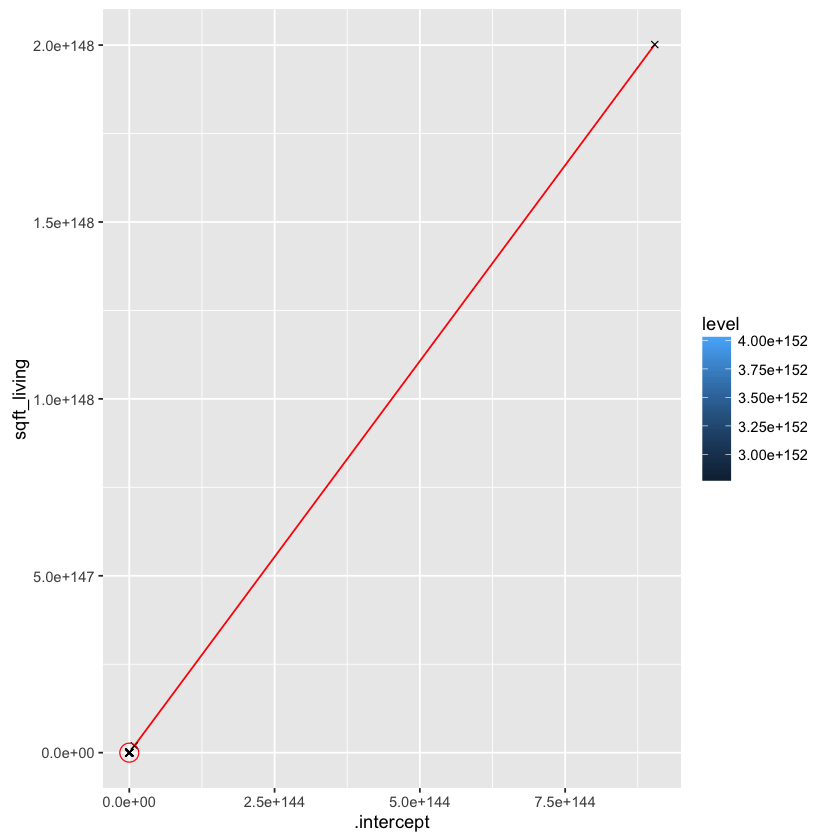

[1] "weightsTst:"
[1]  9.041989e+144  2.001528e+148 -2.041561e+149


ERROR: Error in file(con, "rb"): cannot open the connection


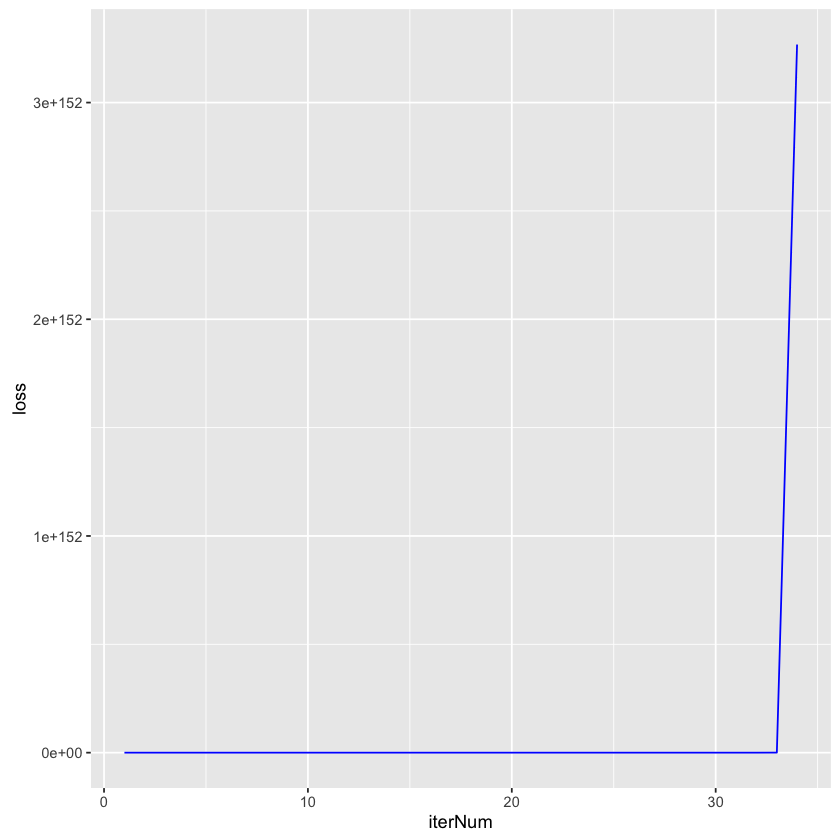

In [14]:
stepSize <- 1e-10; l2Penalty <- 1e+10; maxIterations = 100
weightsTst <-
    optimizeGradientDescent(obsDf = glbObsFit, feats = glbFeats,
                            weightsInitial = weightsZero,
                            stepSize = stepSize,
                            l2Penalty = l2Penalty,
                            lossFn = ridgeRegressionLossFn,
                            lossGradientFn = ridgeRegressionLossGradientFn,
                            maxIterations = maxIterations,
                            verbose = TRUE,
                            maxLoss = 1e156)
print(sprintf('weightsTst:'))
print(weightsTst)

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:2.5896e+16"
[1] "  iteration: 3; loss:4.0710e+16"
[1] "  iteration: 4; loss:1.2427e+17"
[1] "  iteration: 5; loss:7.3467e+17"
[1] "  iteration: 6; loss:1.0526e+18"
[1] "  iteration: 7; loss:4.0486e+18"
[1] "  iteration: 8; loss:2.1377e+19"
[1] "  iteration: 9; loss:2.8029e+19"
[1] "  iteration: 10; loss:1.3229e+20"
[1] "  iteration: 11; loss:6.1525e+20"
[1] "  iteration: 21; loss:1.7507e+25"
[1] "  iteration: 31; loss:3.9636e+30"
[1] "  iteration: 41; loss:1.3597e+35"
[1] "  iteration: 51; loss:2.0660e+40"
[1] "  iteration: 61; loss:1.3237e+45"
[1] "  iteration: 71; loss:8.9048e+49"
[1] "  iteration: 81; loss:1.1396e+55"
[1] "  iteration: 91; loss:3.7318e+59"
  iterNum         loss .intercept sqft_living sqft_living15
1       1 2.589553e+16  0.2658020    642.5520     -877.0091
2       2 4.071048e+16  0.7389954   1396.4963    -1195.2500
3       3 1.242729e+17  0.7435926    661.6606     

ERROR: Error in file(con, "rb"): cannot open the connection


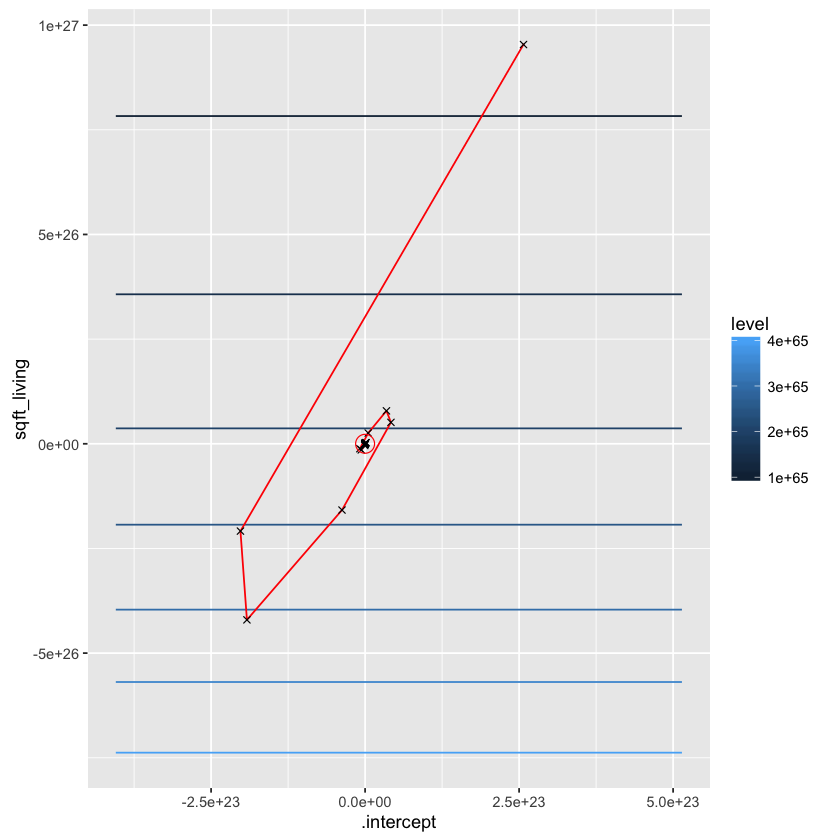

[1] "weightsTest:"
[1]  2.571569e+23  9.536251e+26 -1.787656e+27


ERROR: Error in file(con, "rb"): cannot open the connection


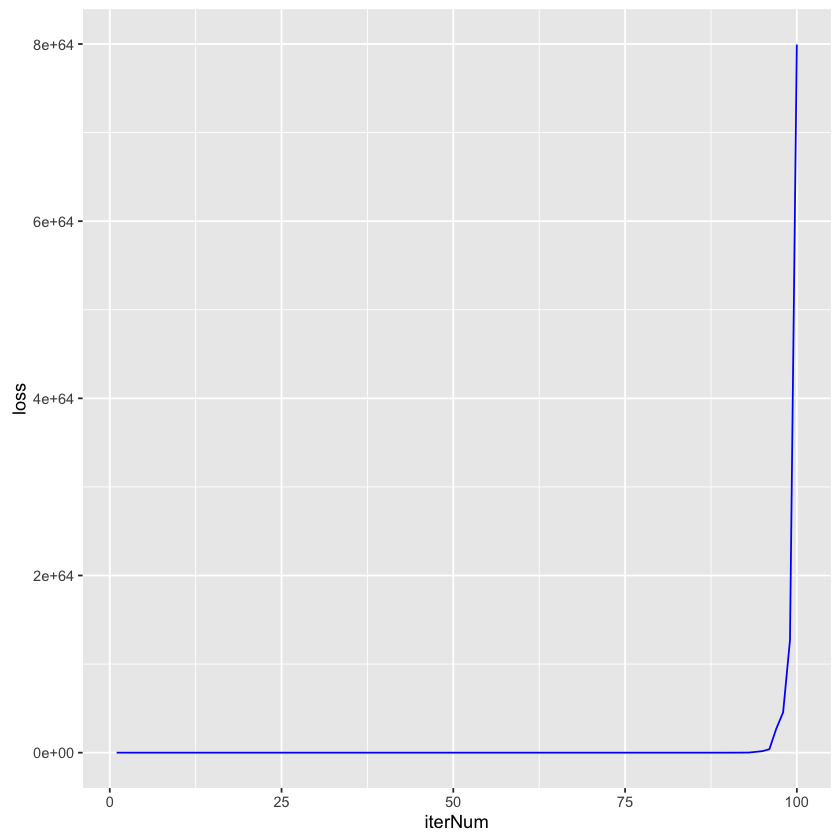

In [15]:
stepSize <- 2e-11; l2Penalty <- 1e+10; maxIterations = 100
weightsTest <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE,
                           maxLoss = 1e155)
print(sprintf('weightsTest:')) 
print(weightsTest)

#### Example: Does converge

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:3.1838e+15"
[1] "  iteration: 3; loss:2.2142e+15"
[1] "  iteration: 4; loss:1.6231e+15"
[1] "  iteration: 5; loss:1.2626e+15"
[1] "  iteration: 6; loss:1.0427e+15"
[1] "  iteration: 7; loss:9.0862e+14"
[1] "  iteration: 8; loss:8.2678e+14"
[1] "  iteration: 9; loss:7.7681e+14"
[1] "  iteration: 10; loss:7.4628e+14"
[1] "  iteration: 11; loss:7.2761e+14"
[1] "  iteration: 21; loss:6.9775e+14"
[1] "  iteration: 31; loss:6.9677e+14"
[1] "  iteration: 41; loss:6.9610e+14"
[1] "  iteration: 51; loss:6.9548e+14"
[1] "  iteration: 61; loss:6.9491e+14"
[1] "  iteration: 71; loss:6.9440e+14"
[1] "  iteration: 81; loss:6.9392e+14"
[1] "  iteration: 91; loss:6.9348e+14"
  iterNum         loss .intercept sqft_living sqft_living15
1       1 3.183797e+15 0.01329010    32.12761      25.68841
2       2 2.214216e+15 0.02361618    57.25447      45.69407
3       3 1.623061e+15 0.03162838    76.91576     

ERROR: Error in file(con, "rb"): cannot open the connection


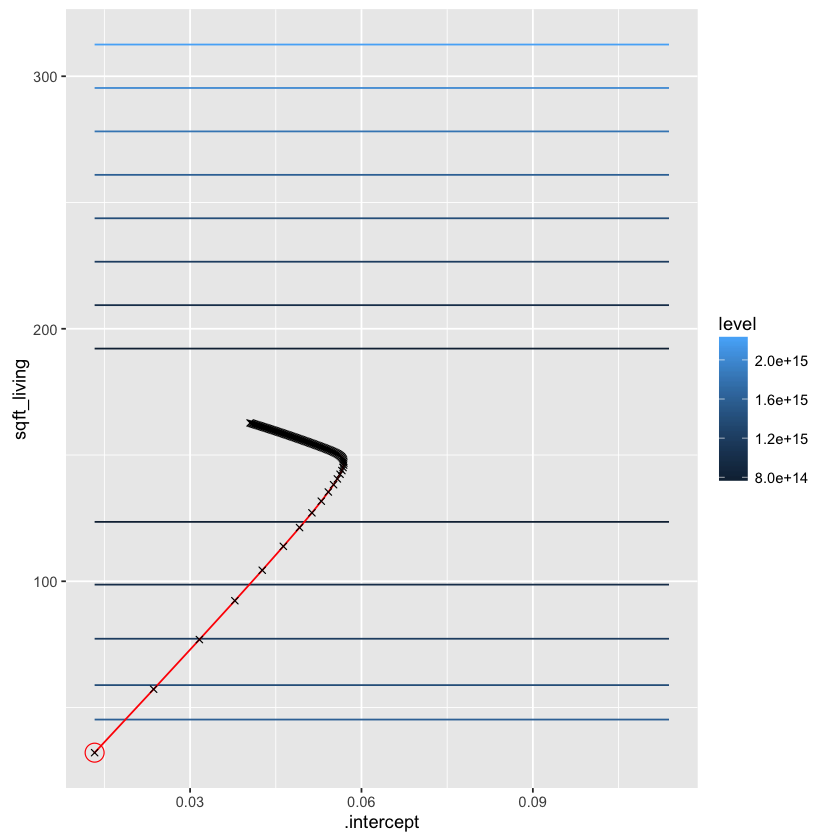

[1] "weightsL2Zero:"
[1]   0.04050541 162.70856430  99.68639470


ERROR: Error in file(con, "rb"): cannot open the connection


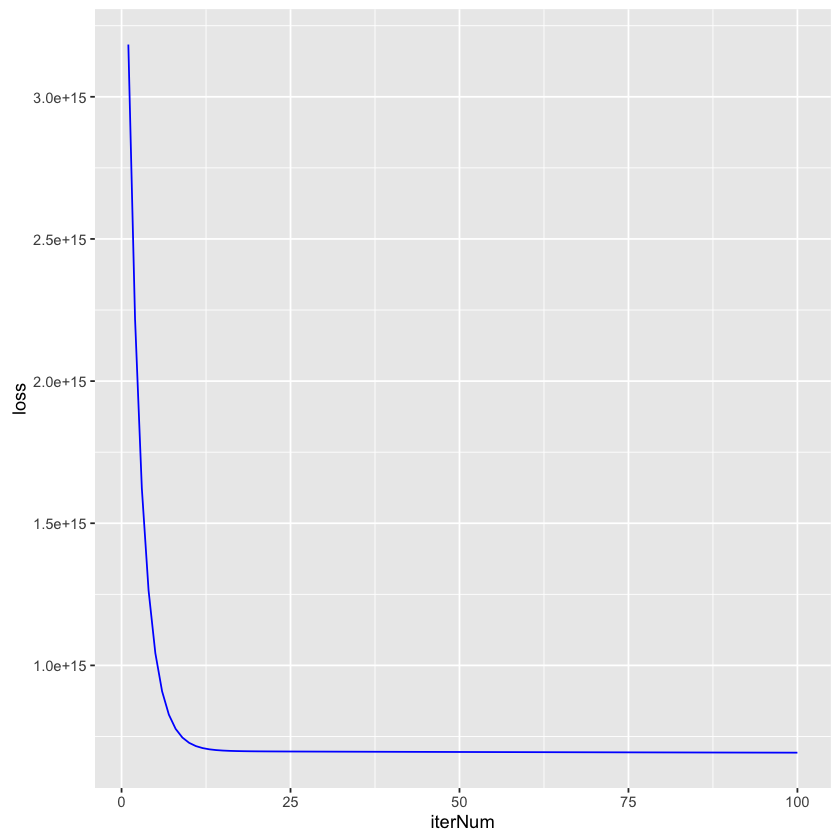

In [16]:
stepSize <- 1e-12; l2Penalty <- 0.0; maxIterations = 100
weightsL2Zero <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE)
print(sprintf('weightsL2Zero:')) 
print(weightsL2Zero)

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:3.2007e+15"
[1] "  iteration: 3; loss:2.2873e+15"
[1] "  iteration: 4; loss:1.7570e+15"
[1] "  iteration: 5; loss:1.4492e+15"
[1] "  iteration: 6; loss:1.2705e+15"
[1] "  iteration: 7; loss:1.1667e+15"
[1] "  iteration: 8; loss:1.1065e+15"
[1] "  iteration: 9; loss:1.0715e+15"
[1] "  iteration: 10; loss:1.0512e+15"
[1] "  iteration: 11; loss:1.0394e+15"
[1] "  iteration: 21; loss:1.0232e+15"
[1] "  iteration: 31; loss:1.0231e+15"
[1] "  iteration: 41; loss:1.0231e+15"
[1] "  iteration: 51; loss:1.0231e+15"
[1] "  iteration: 61; loss:1.0231e+15"
[1] "  iteration: 71; loss:1.0231e+15"
[1] "  iteration: 81; loss:1.0231e+15"
[1] "  iteration: 91; loss:1.0231e+15"
  iterNum         loss .intercept sqft_living sqft_living15
1       1 3.200718e+15 0.01329010    32.12761      25.68841
2       2 2.287293e+15 0.02361618    56.61192      45.25350
3       3 1.757032e+15 0.03168400    75.27265     

ERROR: Error in file(con, "rb"): cannot open the connection


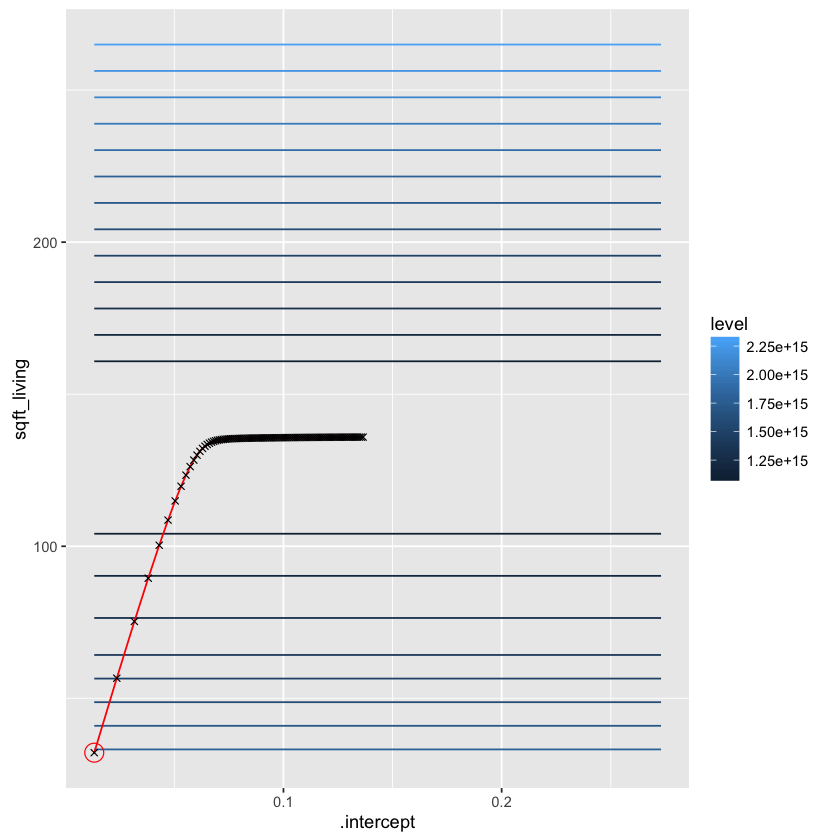

[1] "weightsL2Hgh:"
[1]   0.1365188 135.8948979 106.8612538


ERROR: Error in file(con, "rb"): cannot open the connection


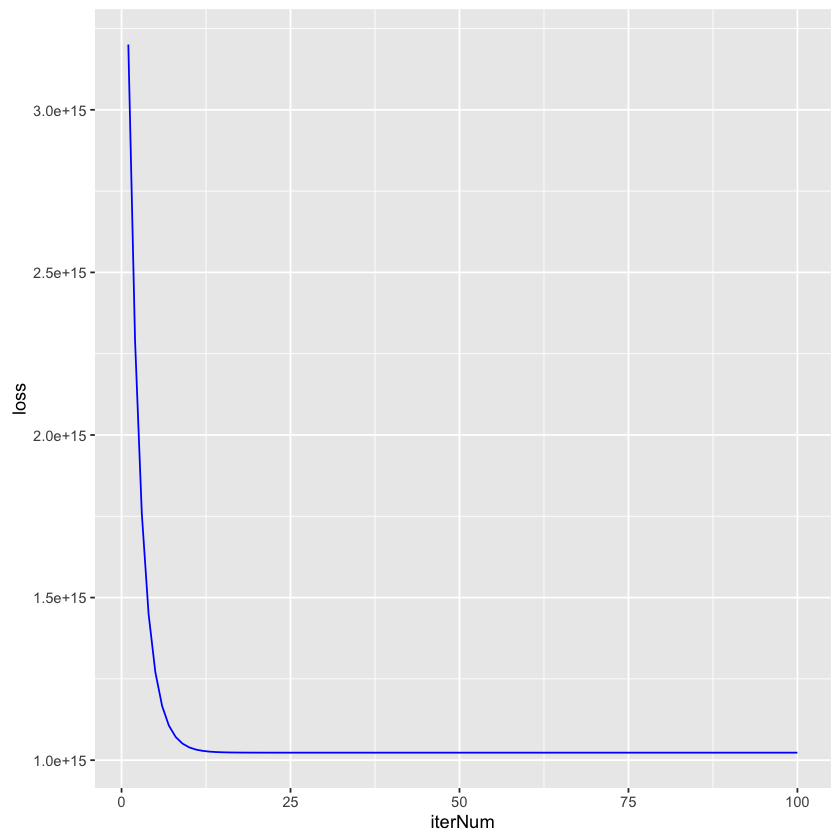

In [17]:
stepSize <- 1e-12; l2Penalty <- 1e10; maxIterations = 100
weightsL2Hgh <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE)
print(sprintf('weightsL2Hgh:')) 
print(weightsL2Hgh)

### Find best model parameters

In [18]:
getObsRSS <- function(obsDf, feats, weights) {
    return(sum((obsDf[, glb_rsp_var] - 
                predictOutput(obsDf, feats, weights)) ^ 2))
}    

In [19]:
mdlLst <- list()

In [20]:
savMdlDf <- mdlDf

In [21]:
maxIterations <- 100

mdlDf <- expand.grid(stepSize  = c(1e-13, 1e-12, 1e-11, 2e-11), 
                     l2Penalty = c(0, 1e-1, 1e0, 1e+1, 1e+2))
# mdlDf <- expand.grid(stepSize  = c(1e-13, 1e-12), 
#                      l2Penalty = c(1e+02, 1e+04))
resDf <- foreach(mdlIx = 1:nrow(mdlDf), .combine = rbind) %do% {
    print("")
    print(sprintf(
        "Running optimizeGradientDescent for l2Penalty:%0.4e",
          mdlDf[mdlIx, 'l2Penalty']))
    mdlWeights <- 
        optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                                mdlDf[mdlIx, 'stepSize'], 
                                mdlDf[mdlIx, 'l2Penalty'], 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                                maxIterations, verbose = FALSE)
    print('  mdlWeights:')
    print(mdlWeights)
    thsRes <- data.frame(matrix(c(mdlWeights, 
                           getObsRSS(glbObsOOB, glbFeats, mdlWeights)),
                               nrow = 1))
    row.names(thsRes) <- mdlIx
    thsRes
}    
names(resDf) <- c('.intercept', glbFeats, 'OOBRSS')
mdlDf <- cbind(mdlDf, resDf)
print(dplyr::arrange(mdlDf, desc(OOBRSS)))

[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:0.0000e+00"
[1] "  mdlWeights:"
[1]   0.05047027 126.91799042 111.79525381
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:0.0000e+00"
[1] "  mdlWeights:"
[1]   0.04050541 162.70856430  99.68639470
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:0.0000e+00"
[1] "  mdlWeights:"
[1]  -0.01798737 194.49620358  65.50305879
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:0.0000e+00"
[1] "  mdlWeights:"
[1] -7.612599e+12 -1.240304e+16  1.123241e+16
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:1.0000e-01"
[1] "  mdlWeights:"
[1]   0.05047027 126.91799042 111.79525381
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:1.0000e-01"
[1] "  mdlWeights:"
[1]   0.04050541 162.70856430  99.68639470
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:1.0000e-01"
[1] "  mdlWeights:"
[1]  -0.01798737 194.49620358  65.50305879
[1] ""
[1] "Running optimizeGradientDescent for l2Penalty:1.0000e-

ERROR: Error in file(con, "rb"): cannot open the connection


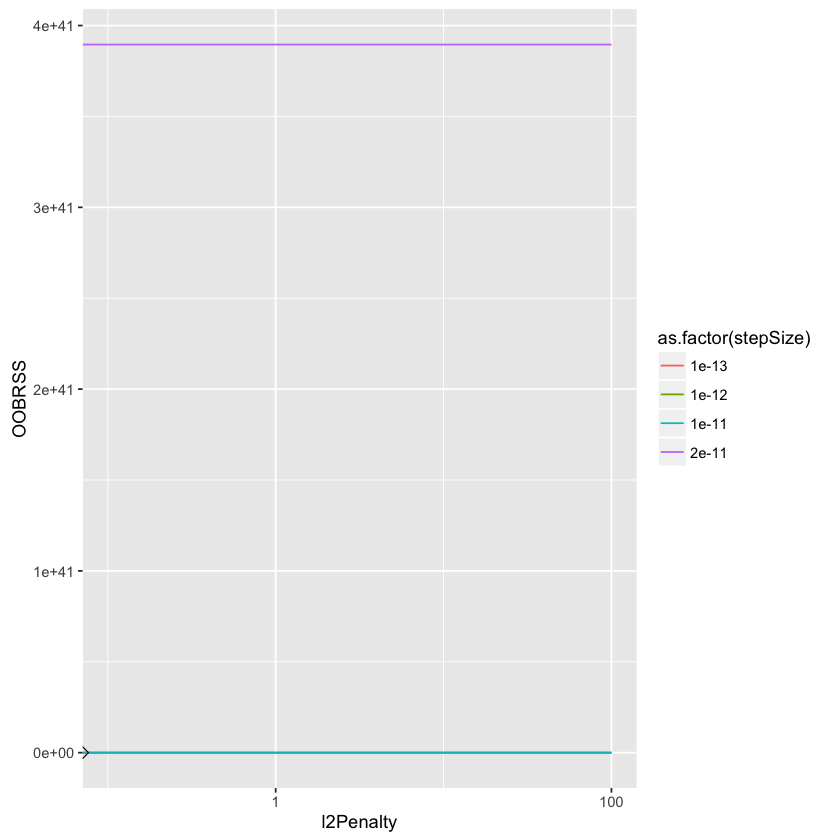

In [22]:
print(ggplot(mdlDf, aes(x = l2Penalty, y = OOBRSS, group = stepSize)) + 
      geom_line(aes(color = as.factor(stepSize))) + 
      scale_x_log10() + 
      geom_point(data = mdlDf[which.min(mdlDf$OOBRSS), ], 
                 shape = 5, color = 'black', size = 2))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


ERROR: Error in file(con, "rb"): cannot open the connection


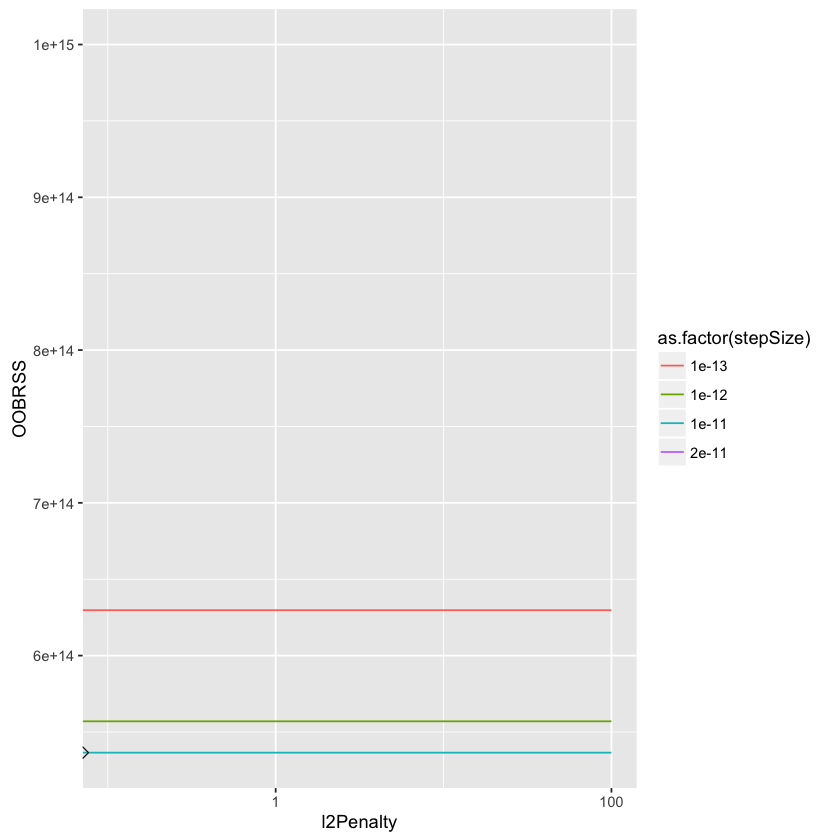

In [23]:
#pltMdlDf <- subset(mdlDf, OOBRSS < 1e+41)
pltMdlDf <- mdlDf
print(ggplot(pltMdlDf, aes(x = l2Penalty, y = OOBRSS, group = stepSize)) + 
      geom_line(aes(color = as.factor(stepSize))) + 
      scale_x_log10() + 
      geom_point(data = mdlDf[which.min(mdlDf$OOBRSS), ], 
                 shape = 5, color = 'black', size = 2) + 
      scale_y_log10() + 
      ylim(c(NA, 1e+15))
     )

## Predict New data

In [24]:
print(" ")
print(sprintf("weightsZero:")) 
print(weightsZero)
print(sprintf("  glbObsNew RSS: %.4e", 
              getObsRSS(glbObsNew, glbFeats, weightsZero)))

print(" ")
print(sprintf('weightsL2Zero:')) 
print(weightsL2Zero)
print(sprintf('  glbObsNew RSS: %.4e', 
              getObsRSS(glbObsNew, glbFeats, weightsL2Zero)))

[1] " "
[1] "weightsZero:"
[1] 0 0 0
[1] "  glbObsNew RSS: 1.7843e+15"
[1] " "
[1] "weightsL2Zero:"
[1]   0.04050541 162.70856430  99.68639470
[1] "  glbObsNew RSS: 2.8102e+14"


In [25]:
print(sprintf("glbObsNew Obs 1 %s:%0.4f", 
              glb_rsp_var, glbObsNew[1, glb_rsp_var]))

print(" ")
print(sprintf("  weightsZero   %s prediction:%0.4f; error.abs:%0.4f", 
              glb_rsp_var, 
    prediction <- predictOutput(glbObsNew[1, ], glbFeats, weightsZero  ), 
              abs(prediction - glbObsNew[1, glb_rsp_var])))

print(" ")
print(sprintf("  weightsL2Zero %s prediction:%0.4f; error.abs:%0.4f", 
              glb_rsp_var, 
    prediction <- predictOutput(glbObsNew[1, ], glbFeats, weightsL2Zero), 
              abs(prediction - glbObsNew[1, glb_rsp_var])))

[1] "glbObsNew Obs 1 price:310000.0000"
[1] " "
[1] "  weightsZero   price prediction:0.0000; error.abs:310000.0000"
[1] " "
[1] "  weightsL2Zero price prediction:410115.0700; error.abs:100115.0700"


In [26]:
print(sessionInfo())

R version 3.2.2 (2015-08-14)
Platform: x86_64-apple-darwin15.0.0 (64-bit)
Running under: OS X 10.11.3 (El Capitan)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] caTools_1.17.1  doBy_4.5-14     survival_2.38-3 caret_6.0-65   
 [5] ggplot2_2.0.0   lattice_0.20-33 Cairo_1.5-9     doMC_1.3.4     
 [9] iterators_1.0.8 foreach_1.4.3  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.3        compiler_3.2.2     nloptr_1.0.4       plyr_1.8.3        
 [5] bitops_1.0-6       base64enc_0.1-3    tools_3.2.2        digest_0.6.9      
 [9] lme4_1.1-11        uuid_0.1-2         jsonlite_0.9.19    evaluate_0.8      
[13] gtable_0.1.2       nlme_3.1-124       mgcv_1.8-11        Matrix_1.2-3      
[17] DBI_0.3.1          IRdisplay_0.3      IRkernel_0.5       SparseM_1.7       
[21] rzmq_0.7.7         dplyr_0.4.3        repr